# Ising Model Simulation

This Jupyter notebook simulates the 2D Ising model to calculate various observables such as magnetization, energy, susceptibility, and specific heat as functions of temperature. We also compute the correlation function and study how the correlation length depends on temperature. We use units where $J=k=1$.
Remember that in a Ising Model the Hamiltonian of the model is:
$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$ where $S_{ij}$ is the spin of an element of the lattice.
The main goal is to observe how, near $T\approx 2.27$ and for a sufficiently large lattice, these observables exhibit a *sharp* behavior. In a finite lattice, we do not expect to find a true phase transition, but simulations on finite lattices should indicate this behavior.

Exact partition function calculations are feasible for lattices with a few hundred spins per side. For a $512 \times 512$ lattice, about 8 GB of memory is needed to store the partition function, making exact calculations impractical for larger lattices. However, numerical experiments can handle much larger lattices by generating random states of the lattice according to the canonical ensemble and averaging over these states.

To achieve this, we start from an arbitrary initial state and apply the **Metropolis algorithm**, which involves the following steps:

1. Select a random site on the lattice.
2. Calculate the energy difference $\Delta E$ resulting from flipping the spin at that site.
3. If $\Delta E \le 0$, flip the spin; if $\Delta E > 0$, flip the spin with probability $e^{-\beta\Delta E}$.


This process is iterated many times, and after sufficient iterations, the algorithm generates states distributed according to the canonical ensemble. By averaging over several of these states, we can compute the observables of interest.

This notebook is designed with practicality in mind, so the goal is not to conduct experiments on excessively large lattices.




# Library - third party libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit
import random
from tqdm import tqdm
import pandas as pd

The Metropolis function consists of $L \times L$ iterations of the same algorithm. This involves selecting a random spin and determining the resulting energy difference $\Delta E$ from flipping it, calculated using the reasoning explained below. Based on the value of $\Delta E$, it is decided whether to flip the spin according to the previously described criteria. If the spin is flipped, the state of the lattice is updated, and the resulting differences in energy and magnetization per particle are recorded.

Explanation of the $\Delta E$ term:

If the value of $S_{i,j}$ is changed, the only change in the energy of the lattice comes from the four interaction terms with its four nearest neighbors:

Defining the sum of the spins of the four nearest neighbors of $S_{i,j}$ as:
$$S_{nn} = S_{i+1,j} + S_{i-1,j} + S_{i,j+1} + S_{i,j-1} $$

Then, the four interaction terms with its four nearest neighbors are:
$$e_{i,j} = -S_{i,j} \cdot S_{nn} $$

Therefore, $\Delta E$ is calculated as:
$$\Delta E = e_{i,j}^{final} - e_{i,j}^{initial} = (-(-S_{i,j}) \cdot S_{nn}) - (-S_{i,j} \cdot S_{nn}) = 2S_{i,j} \cdot S_{nn}$$




In [ ]:

# Define the function h(S), which calculates the energy per particle of the lattice in state S.
def h(S):
    L = len(S)
    H = 0
    for i in range(L):
        for j in range(L):
            H += S[i, j] * (S[(i + 1) % L, j] + S[i, (j + 1) % L])  # sum only first neighbor interactions
            '''
            For a fixed i and sweeping over j:
            In the case i, j = 49, 49 --> ((i + 1) % L, j) = (0, 49) and (i, (j + 1) % L) = (49, 0), which are the first neighbors in periodic boundary conditions.
            The function (1 + i) % L returns i + 1 except when i = L - 1 (last element of the list L), in that case, it returns 0.
            In an intermediate case i, j = 5, 5, the interactions are with the neighbors (6 % L, 5) and (5, 6 % L), which are (6, 5) and (5, 6).
            Sweeping over i recovers the other corresponding first neighbors.
            '''
    return -H / L**2

@njit  # Compile the function
def metropolis(S, prob):  # Apply the Metropolis algorithm to state S
    L = S.shape[0]
    dm = 0
    de = 0
    for iter in range(L * L):
        i = np.random.randint(L)
        j = np.random.randint(L)

        # Define the sum of spins with the 4 nearest neighbors
        S_nn = S[(i - 1) % L, j] + S[i, (j - 1) % L] + S[(i + 1) % L, j] + S[i, (j + 1) % L]
        # Calculate the energy difference (explanation below)
        dE = 2 * S[i, j] * S_nn

        if dE <= 0:  # Flip the spin
            S[i, j] *= -1
            dm += 2 * S[i, j] / L**2  # Calculate the change in magnetization per particle
            de += dE / L**2           # Calculate the change in energy per particle
        else:  # Flip the spin with certain probability
            if np.random.rand() < prob[int(dE / 4 - 1)]:  # Use that dE is 4 or 8, so int(dE / 4 - 1) gives 0 or 1 respectively
                S[i, j] *= -1
                dm += 2 * S[i, j] / L**2  # Calculate the change in magnetization per particle
                de += dE / L**2           # Calculate the change in energy per particle
    return S, dm, de


In [ ]:
# Check that the recently defined functions are correct by using the suggested test: a 3x3 matrix with all entries as 1's (all spins up in the lattice)
S = np.ones((3, 3))  # 3x3 lattice with all spins up
print(h(S))

# Test the flipping function of the Metropolis algorithm at different temperatures, expressed as different values of the probability vector (prob).
# For higher temperatures (T= 50 K):
prob = [0.92, 0.85]
S_f, dE, dM = metropolis(S, prob)
print(S_f, dE, dM)

# Decrease the temperature (T=20 K):
prob2 = [0.82, 0.67]
S_f2, dE2, dM2 = metropolis(S, prob2)
print(S_f2, dE2, dM2)

# Decrease the temperature (T=5 K):
prob3 = [0.45, 0.20]
S_f3, dE3, dM3 = metropolis(S, prob3)
print(S_f3, dE3, dM3)



-2.0


/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'prob' of function 'metropolis'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-8-3ff74ee9ca96>", line 19:
@njit # Compila la función
def metropolis(S,prob): # Aplico el algoritmo de Metropolis al estado S
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[[-1.  1.  1.]
 [-1.  1.  1.]
 [ 1. -1. -1.]] -0.888888888888889 2.6666666666666665
[[ 1.  1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]] 0.0 -0.4444444444444444
[[ 1.  1.  1.]
 [-1. -1.  1.]
 [-1. -1. -1.]] -0.2222222222222222 -0.4444444444444444


In [ ]:
# Verification that this part of the algorithm is correct, since the possible dE values should be -8, -4, 0, 4, 8
dE_list = []
dM_list = []
for _ in range(10000):
    L = 10
    S = 2 * np.random.randint(2, size=(L, L)) - 1  # Generate a new random lattice

    i = np.random.randint(L)
    j = np.random.randint(L)

    # Define the sum of spins with the 4 nearest neighbors
    S_nn = S[(i - 1) % L, j] + S[i, (j - 1) % L] + S[(i + 1) % L, j] + S[i, (j + 1) % L]
    # Calculate the energy difference
    dE = 2 * S[i, j] * S_nn
    dM = 2 * S[i, j]

    dE_list.append(dE)
    dM_list.append(dM)

print('The values of dE were: ', set(dE_list))
print('The values of dM were: ', set(dM_list))


Los valores de dE fueron:  {0, 4, 8, -8, -4}
Los valores de dM fueron:  {2, -2}


# Thermalization

Starting from a certain initial state, we study how many steps are necessary for the system to reach equilibrium, that is, for the different states to start being distributed according to the canonical ensemble. To do this, we plot the magnetization and energy per particle as a function of the step; equilibrium is reached when these quantities start to fluctuate around a fixed value, rather than being steadily increasing or decreasing.

The number of steps needed to reach equilibrium will depend on the temperature, so this analysis must be done for various temperatures. It can also depend on the size of the lattice, so when changing this parameter, you will need to redo this analysis. Note that near the critical temperature, the magnetization oscillates between $1$ and $-1$.


100%|██████████| 19999/19999 [00:01<00:00, 16177.56it/s]


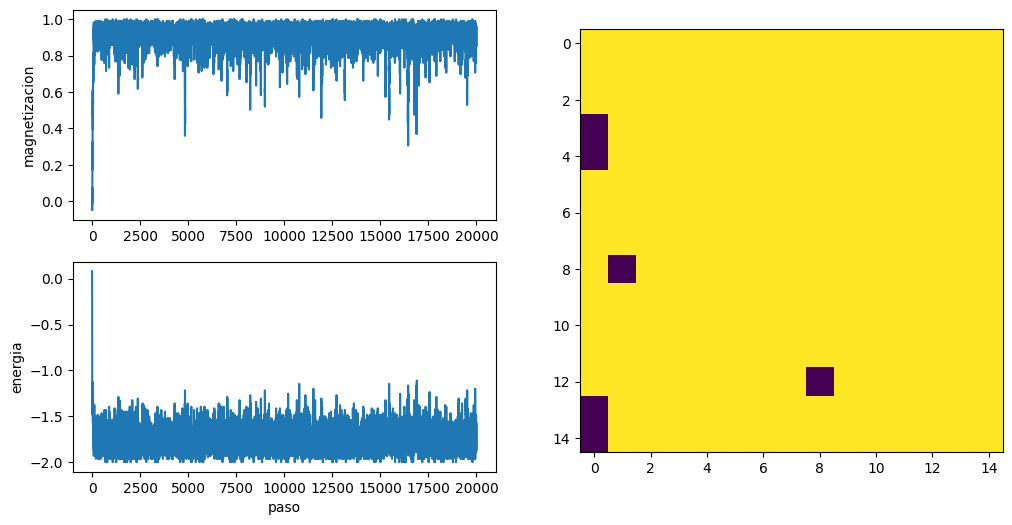

In [ ]:

L = 15  # Lattice size
beta = 1/2  # Temperature

nequilibrium = 20000  # Tentative number of steps to reach equilibrium

prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

# Initial state
# Option 1: all spins pointing up
# S = -np.ones((L, L), dtype=int)
# Option 2: random matrix of 1's and -1's
S = 2 * np.random.randint(2, size=(L, L)) - 1

m = np.zeros(nequilibrium)  # Magnetization as a function of the step
e = np.zeros(nequilibrium)  # Energy per particle as a function of the step
m[0] = np.mean(S)
e[0] = h(S)

for n in tqdm(range(1, nequilibrium)):
    S, dm, de = metropolis(S, prob)
    m[n] = m[n - 1] + dm
    e[n] = e[n - 1] + de

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(m)
plt.ylabel('Magnetization')
plt.subplot(2, 2, 3)
plt.plot(e)
plt.ylabel('Energy')
plt.xlabel('Step')
plt.subplot(1, 2, 2)
plt.imshow(S)  # Plot the final state, giving a different color to 1 and -1
plt.show()


$T = 1$
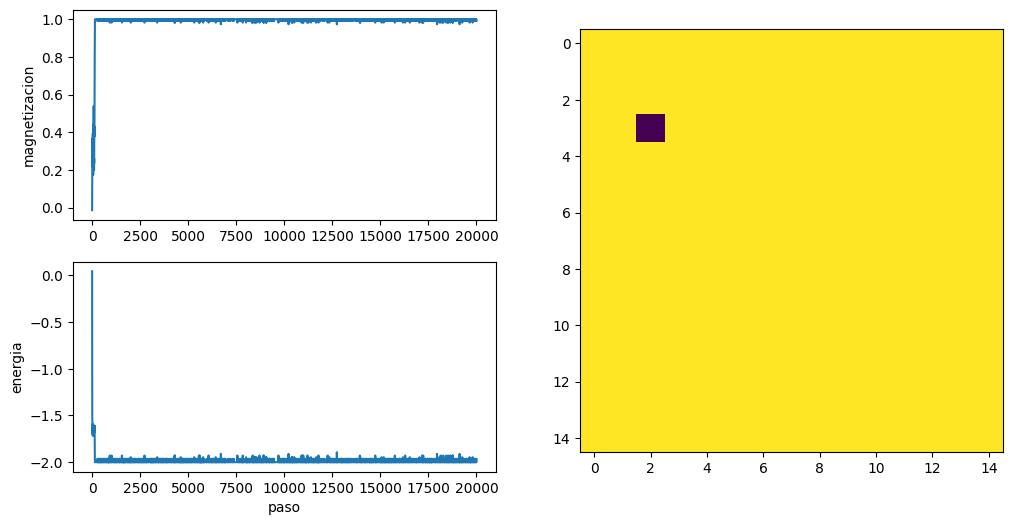

# Averages

We study how many steps are needed to calculate reliable averages. To do this, we plot the average value of magnetization and energy per particle as a function of the number of steps used to calculate them (starting to count after reaching equilibrium). When the average value becomes constant, the number of steps will be sufficient. Again, the appropriate number of steps depends on the temperature and the lattice size. You will see that, near the critical temperature, fluctuations become larger, and therefore, it is necessary to average over a larger number of steps. To avoid the unmanageable fluctuations of magnetization between $1$ and $-1$ near the critical temperature, we take **the average of its absolute value**.


100%|██████████| 19999/19999 [00:46<00:00, 425.59it/s]


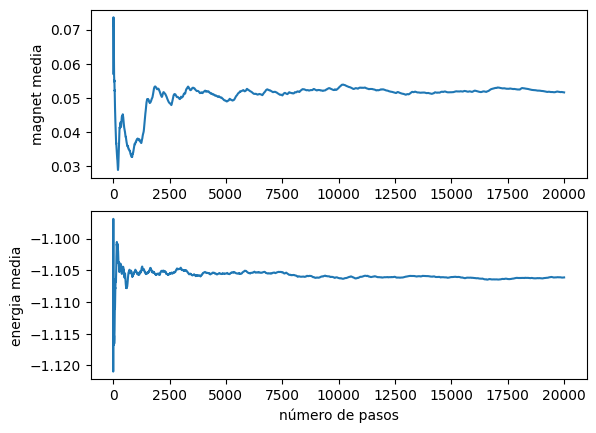

In [ ]:

L = 120
beta = 1 / 2.5

nequilibrium = 1000  # Number of steps decided based on previous analysis
naverage = 20000  # Tentative number of steps to calculate averages

prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

S = np.ones((L, L), dtype=int)  # Initial state

for _ in tqdm(range(nequilibrium)):
    S, _, _ = metropolis(S, prob)  # Thermalize

m = np.zeros(naverage)
e = np.zeros(naverage)  # Magnetization and energy per particle as a function of steps
m[0] = np.mean(S)
e[0] = h(S)

m_avg = [abs(m[0])]
e_avg = [e[0]]  # Average values as a function of the number of steps

for n in tqdm(range(1, naverage)):
    S, _, _ = metropolis(S, prob)
    m[n] = m[n - 1] + dm
    e[n] = e[n - 1] + de
    m_avg.append(np.mean(abs(m[:n + 1])))
    e_avg.append(np.mean(e[:n + 1]))

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(m_avg)
plt.ylabel('Average Magnetization')
plt.subplot(2, 1, 2)
plt.plot(e_avg)
plt.ylabel('Average Energy')
plt.xlabel('Number of Steps')
plt.show()


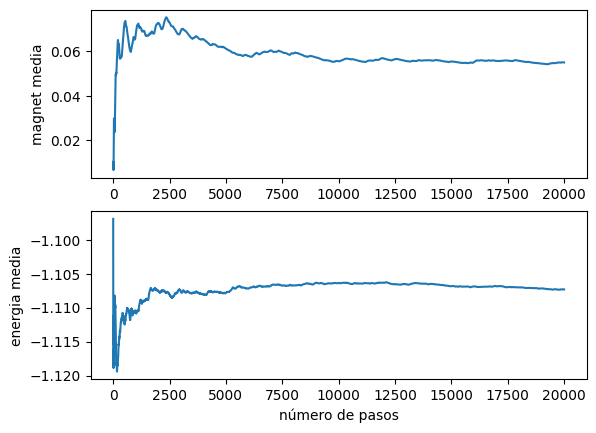

# Phase Transition

Calculate the average magnetization, average energy per particle, susceptibility, and specific heat for various temperatures. Plot the results and observe the sharp behavior near the critical temperature.

- Use the relationship between these quantities and the variance of magnetization and energy per particle to compute susceptibility and specific heat, avoiding derivatives.
- Reuse the final state of the previous temperature to start, reducing thermalization steps. Use a matrix of ones for low temperatures and a random matrix for high temperatures.
- Take more steps for thermalization and averaging near the critical temperature compared to far from it.

Typical plots include susceptibility, which may need improvement.


In [ ]:

L = 30  # Lattice size
beta = np.linspace(1 / 1.5, 1 / 3.5, 50)  # Beta values for different temperatures

nequilibrium = 2000  # Tentative number of steps to reach equilibrium
naverage = 20000  # Tentative number of steps for averaging

# Initial state: 30x30 matrix with all spins up
S = np.ones((L, L), dtype=int)

# Thermalize the system
for _ in tqdm(range(nequilibrium)):
    prob = np.array([np.exp(-4 * beta[0]), np.exp(-8 * beta[0])])
    S, _, _ = metropolis(S, prob)

E = []  # List for average energies
M = []  # List for average magnetizations
E2 = []  # List for squared macroscopic energies
M2 = []  # List for squared macroscopic magnetizations

# Loop over different temperatures
for T in range(len(beta)):
    prob = np.array([np.exp(-4 * beta[T]), np.exp(-8 * beta[T])])
    m = np.zeros(naverage)
    e = np.zeros(naverage)
    m[0] = np.mean(S)
    e[0] = h(S)

    MMacro2 = np.zeros(naverage)
    Emacro2 = np.zeros(naverage)
    MMacro2[0] = (m[0] * L**2)**2
    Emacro2[0] = (e[0] * L**2)**2

    m_avg = [abs(m[0])]
    e_avg = [e[0]]
    M2_avg = [MMacro2[0]]
    E2_avg = [Emacro2[0]]

    # Average values over steps
    for n in tqdm(range(1, naverage)):
        S, dm, de = metropolis(S, prob)
        m[n] = m[n - 1] + dm
        e[n] = e[n - 1] + de
        m_avg.append(np.mean(abs(m[:n + 1])))
        e_avg.append(np.mean(e[:n + 1]))

        MMacro2[n] = (m[n] * L**2)**2
        Emacro2[n] = (e[n] * L**2)**2
        M2_avg.append(np.mean(MMacro2[:n + 1]))
        E2_avg.append(np.mean(Emacro2[:n + 1]))

    E.append(e_avg[-1])
    M.append(m_avg[-1])
    E2.append(E2_avg[-1])
    M2.append(M2_avg[-1])

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(beta, M, label='Magnetization')
plt.xlabel('Beta')
plt.ylabel('Magnetization')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(beta, E, label='Energy')
plt.xlabel('Beta')
plt.ylabel('Energy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(beta, np.array(M2) - np.array(M)**2, label='Susceptibility')
plt.xlabel('Beta')
plt.ylabel('Susceptibility')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(beta, np.array(E2) - np.array(E)**2, label='Specific Heat')
plt.xlabel('Beta')
plt.ylabel('Specific Heat')
plt.legend()

plt.tight_layout()
plt.show()


100%|██████████| 19999/19999 [00:02<00:00, 6695.48it/s]


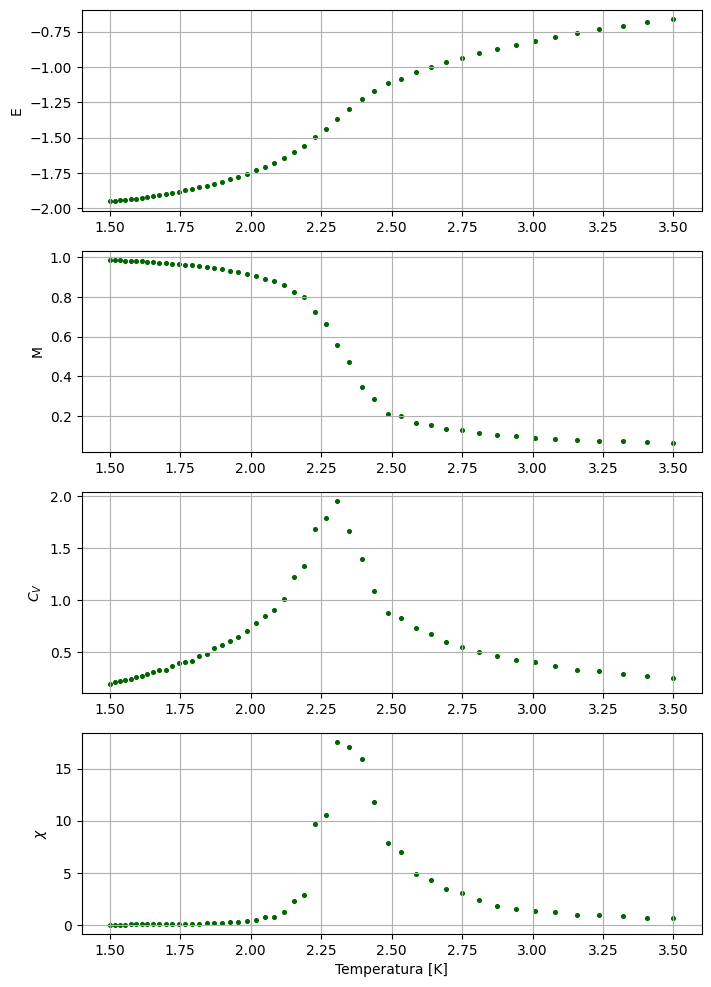

In [ ]:

# Beta values
beta = np.linspace(1/1.5, 1/3.5, 50)
T = np.array(1 / beta)  # Temperatures

# Observables
e = np.array(E)   # Average energy per particle
m = np.array(M)   # Average magnetization per particle
e2 = np.array(E2) # Average squared energy
m2 = np.array(M2) # Average squared magnetization

L = 30  # Lattice size

# Compute specific heat (cv) and susceptibility (chi)
cv = []
chi = []

for i in range(len(beta)):
    cvi = (beta[i]**2 * (e2[i] - (e[i] * L**2)**2)) / (L**2)
    chii = (beta[i] * (m2[i] - (m[i] * L**2)**2)) / (L**2)
    cv.append(cvi)
    chi.append(chii)

cv = np.array(cv)
chi = np.array(chi)

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(8, 12))
fig.suptitle('Observables vs Temperature')

axs[0].scatter(T, e, color='darkgreen', s=7)
axs[0].set_ylabel('E')
axs[0].grid(True)

axs[1].scatter(T, m, color='darkgreen', s=7)
axs[1].set_ylabel('M')
axs[1].grid(True)

axs[2].scatter(T, cv, color='darkgreen', s=7)
axs[2].set_ylabel(r'$C_{V}$')
axs[2].grid(True)

axs[3].scatter(T, chi, color='darkgreen', s=7)
axs[3].set_ylabel(r'$\chi$')
axs[3].set_xlabel('Temperature [K]')
axs[3].grid(True)

plt.show()


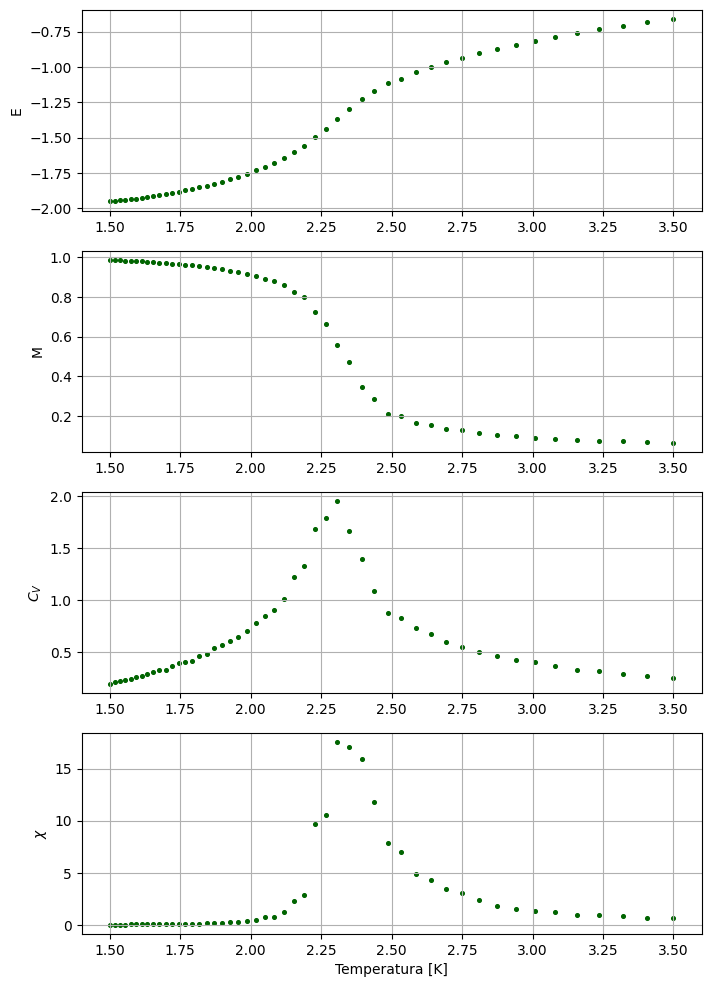

Explanation: We studied a 30x30 two-dimensional lattice to compare experimental results with theoretical expectations. The number of steps required to reach equilibrium (thermalization) and calculate reliable averages was determined by examining the results for various temperatures, using the previous code sections. We considered 50 temperature values between $1.5$ K and $3.5$ K (around the critical temperature), starting with an initial state S of a 30x30 grid with all spins aligned up (represented by a matrix of ones). After thermalizing S using the Metropolis function, we iterated the algorithm 20,000 times for each temperature, calculating the average energy and magnetization per particle at each step. Once the system reached equilibrium and the average values of the observables stabilized (indicating “good averages”), we recorded the final values of energy and magnetization in the lists E and M, respectively.

To calculate the heat capacity at constant volume and magnetic susceptibility, we used their relationships with the fluctuations in energy and magnetization around their mean values (amplitude of energy fluctuations around
𝐸 in the canonical ensemble):


$$C_V=\frac{\beta^2}{L^2}(<E^2>-<E>^2),$$


$$\chi=\frac{\beta}{L^2}  (<M^2>-<M>^2),$$
where 𝐸 and M are the total (macroscopic) energy and magnetization, respectively, and the factor $L^2$ is included to normalize the quantities per particle.

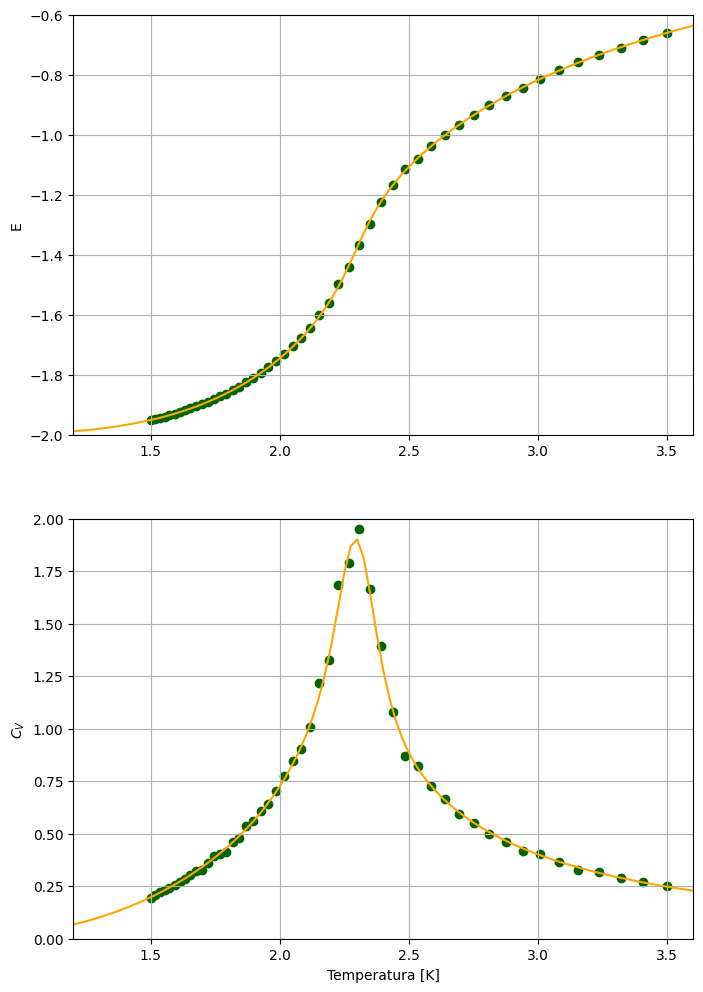

In [ ]:

# Load theoretical data from CSV files
file_U = '/content/U_32x32.csv'
file_C = '/content/C_32x32.csv'

E_archiv = pd.read_csv(file_U)
c_archiv = pd.read_csv(file_C)

# Extract temperature and energy data from the files
col_temperaturas1 = E_archiv['0.025']
col_energias = E_archiv['2.']
T1 = np.array(col_temperaturas1)
Eteorica = np.array(col_energias)
Et = -Eteorica  # Negate to match experimental results

# Extract temperature and heat capacity data from the files
col_temperaturas2 = c_archiv['0.025']
col_caloresp = c_archiv['0.']
T2 = np.array(col_temperaturas2)
ce = np.array(col_caloresp)

# Plot the experimental vs theoretical results
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
plt.grid()

# Plot energy
axs[0].scatter(T, e, color='darkgreen', label='Experimental Data')
axs[0].plot(T1, Et, color='orange', label='Theoretical Values')
axs[0].set_ylabel('Energy (E)')
axs[0].set_xlim(1.2, 3.6)
axs[0].set_ylim(-2, -0.6)
axs[0].legend()
axs[0].grid()

# Plot heat capacity
axs[1].scatter(T, cv, color='darkgreen', label='Experimental Data')
axs[1].plot(T2, ce, color='orange', label='Theoretical Values')
axs[1].set_ylabel(r'Heat Capacity ($C_V$)')
axs[1].set_xlim(1.2, 3.6)
axs[1].set_ylim(0, 2)
axs[1].set_xlabel("Temperature [K]")
axs[1].legend()
axs[1].grid(True)

plt.show()


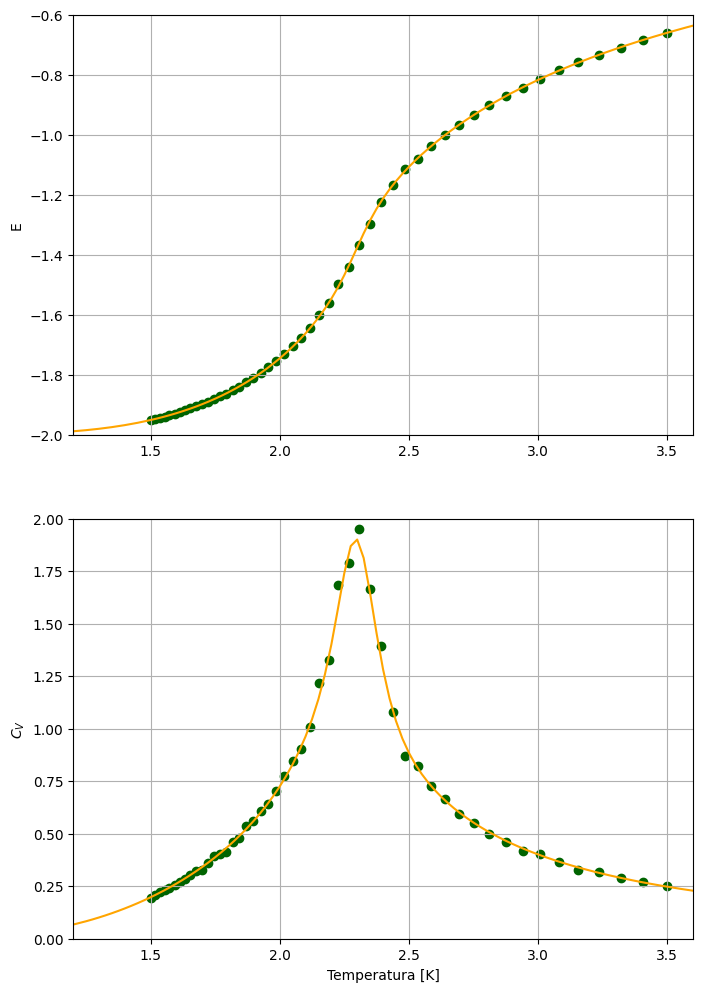

# Correlations

The **correlation function** is defined as:

$$
g(r) = \langle s_{ij} s_{ij+r} \rangle - \langle s_{ij} \rangle \langle s_{ij+r} \rangle
$$

where:
- $\langle s_{ij} s_{ij+r} \rangle$ is the average of the product of spins at positions $(i, j)$ and $(i+r, j)$.
- $\langle s_{ij} \rangle$ is the average spin at position $(i, j)$.

It is known that this function has the form:

$$
g(r) = a e^{-r/\xi}
$$

where:
- $a$ is a constant.
- $\xi$ is the **correlation length**, which depends on the temperature.

The correlation length $\xi$ is a function of temperature and, in the thermodynamic limit, diverges at the critical temperature. The goal of this section is to observe this behavior.


The first step is to define two functions.

The first function, **`cor(S)`**, returns a vector $c$ with $L/2$ components, where $L$ is the side length of the grid. Each component $r$ is the average of $s_{ij} s_{ij+r}$ over the entire grid, given by:

$$
c(r) = \frac{1}{L^2} \sum_{i,j=1}^L s_{ij} s_{ij+r}.
$$

The second function, **`metropolis2(S, prob)`**, implements the Metropolis algorithm, similar to the **`metropolis(S, prob)`** function. However, this time, instead of returning the new state, the change in magnetization, and the change in energy, it returns the new state, the change in magnetization, and the change in the vector $c$.

When defining these two functions, be sure to pay close attention to periodic boundary conditions and note that $c(0)=1$ regardless of the state, so the increment of $c(0)$ is always $0$.


In [ ]:

@njit
def cor(S):
    L = len(S)
    c = np.zeros(L // 2)
    for r in range(L // 2):
        for i in range(L):
            for j in range(L):
                c[r] += S[i, j] * S[i, (j + r) % L]
    return c / L**2

@njit
def metropolis2(S, prob):
    L = S.shape[0]
    dm = 0
    de = 0
    dc = np.zeros(L // 2)

    for iter in range(L * L):
        i = np.random.randint(L)
        j = np.random.randint(L)

        # Define the sum of spins with the 4 nearest neighbors
        Spv = S[(i - 1) % L, j] + S[i, (j - 1) % L] + S[(i + 1) % L, j] + S[i, (j + 1) % L]
        # Calculate the energy difference
        dE = 2 * S[i, j] * Spv

        if dE <= 0:  # Flip the spin
            S[i, j] *= -1
            dm += 2 * S[i, j] / L**2  # Calculate the change in magnetization per particle

            for r in range(1, L // 2):  # Calculate the dc(r) due to flipping this spin
                dc[r] += 2 / L**2 * (S[i, j] * S[i, (j + r) % L] + S[i, (j - r) % L] * S[i, j])

        else:  # Flip the spin with certain probability
            if np.random.rand() < prob[int(dE / 4 - 1)]:  # Use dE being 4 or 8 so int(dE/4-1) is 0 or 1 respectively
                S[i, j] *= -1
                dm += 2 * S[i, j] / L**2  # Calculate the change in magnetization per particle

                for r in range(1, L // 2):  # Calculate the dc(r) due to flipping this spin
                    dc[r] += 2 / L**2 * (S[i, j] * S[i, (j + r) % L] + S[i, (j - r) % L] * S[i, j])

    return S, dm, dc


Now we use the functions we have just defined to calculate the correlation function at three different temperatures. We fit the obtained data with a function of the form $ a e^{-r/\xi} $, and from this, we obtain the correlation length at these three temperatures.


Longitud de correlacion:


100%|██████████| 49999/49999 [00:08<00:00, 5996.84it/s]


T=1.5 => xi=0.4123915871077005


100%|██████████| 49999/49999 [00:09<00:00, 5054.45it/s]


T=2.3 => xi=2.3796616283091083


100%|██████████| 49999/49999 [00:12<00:00, 4159.09it/s]


T=3 => xi=1.173270768424807


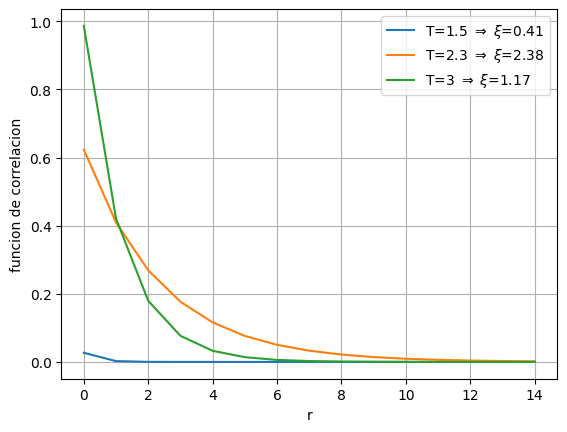

In [ ]:

# Define parameters
L = 30
nequilibrio = 1000
npromedio = 50000

l = int(L / 2)  # Number of components of the vector c
m = np.zeros(npromedio)  # Magnetization as a function of the step
c = np.zeros((l, npromedio))  # Vector c as a function of the step

erres = np.arange(l)  # Domain of the correlation function

def fitcor(r, a, xi):  # Function to fit
    return a * np.exp(-r / xi)

# Define functions for correlation and Metropolis algorithm
def cor(S):
    L = len(S)
    c = np.zeros(L // 2)
    for r in range(L // 2):
        for i in range(L):
            for j in range(L):
                c[r] += S[i, j] * S[i, (j + r) % L]
    return c / L**2

def metropolis2(S, prob):
    L = S.shape[0]
    dm = 0
    de = 0
    dc = np.zeros(L // 2)

    for iter in range(L * L):
        i = np.random.randint(L)
        j = np.random.randint(L)

        # Define the sum of the spins with the 4 nearest neighbors
        Spv = S[(i - 1) % L, j] + S[i, (j - 1) % L] + S[(i + 1) % L, j] + S[i, (j + 1) % L]
        # Calculate the difference in energy
        dE = 2 * S[i, j] * Spv

        if dE <= 0:  # Flip the spin
            S[i, j] *= -1
            dm += 2 * S[i, j] / L**2  # Calculate the change in magnetization per particle

            for r in range(1, L // 2):  # Calculate the change in c(r) that involves flipping this spin
                dc[r] += 2 / L**2 * (S[i, j] * S[i, (j + r) % L] + S[i, (j - r) % L] * S[i, j])

        else:  # Flip the spin with some probability
            if np.random.rand() < prob[int(dE / 4 - 1)]:  # dE is 4 or 8, so int(dE / 4 - 1) yields 0 or 1
                S[i, j] *= -1
                dm += 2 * S[i, j] / L**2  # Calculate the change in magnetization per particle

                for r in range(1, L // 2):  # Calculate the change in c(r) that involves flipping this spin
                    dc[r] += 2 / L**2 * (S[i, j] * S[i, (j + r) % L] + S[i, (j - r) % L] * S[i, j])

    return S, dm, dc

# Initialize the state
S = np.ones((L, L), dtype=int)

print('Correlation length:')

# Calculate the correlation function for different temperatures
for T in [1.5, 2.3, 3]:

    beta = 1 / T
    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

    # Thermalize with the faster metropolis function
    for n in range(nequilibrio):
        S, dm, de = metropolis(S, prob)

    m[0] = np.mean(S)
    c[:, 0] = cor(S)

    for n in tqdm(range(1, npromedio)):
        S, dm, dc = metropolis2(S, prob)
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc

    mmedia = np.mean(abs(m))
    correlacion = np.mean(c, axis=1) - mmedia ** 2  # Correlation function

    # Fit the correlation function
    parametros, covarianza = curve_fit(fitcor, erres, correlacion)
    # (curve_fit returns the best values of the parameters
    # and also the covariance, which we won't use)

    print('T={} => xi={}'.format(T, parametros[1]))

    plt.plot(erres, fitcor(erres, parametros[0], parametros[1]),
             label=r'T={} $\Rightarrow$ $\xi$={}'.format(T, round(parametros[1], 2)))

plt.xlabel('r')
plt.ylabel('Correlation function')
plt.legend()
plt.grid()
plt.show()


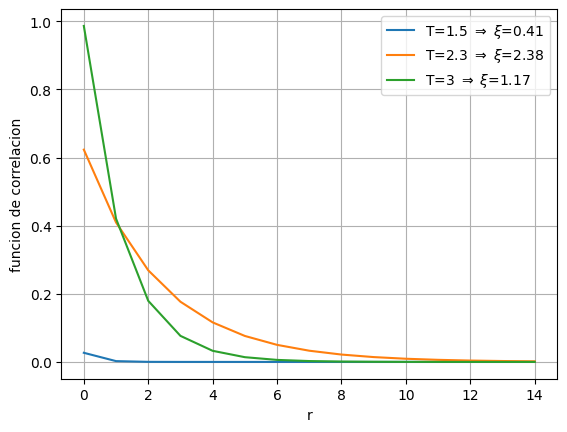

Longitud de correlacion:


100%|██████████| 50/50 [08:16<00:00,  9.94s/it]


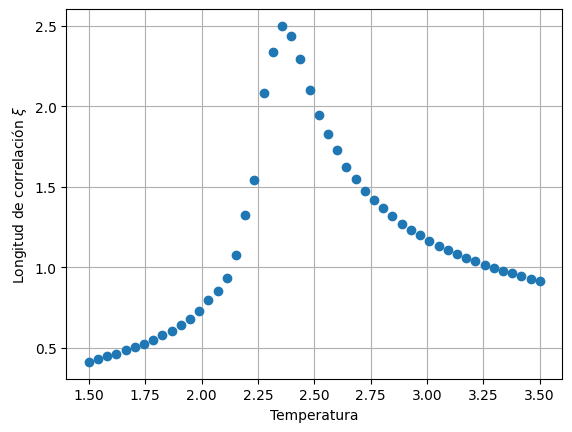

In [ ]:

# Define parameters
L = 30
Tsteps = 50  # Number of temperatures to test
Tmin = 1.5
Tmax = 3.5
nequilibrium = 1000
naverage = 50000

l = int(L / 2)  # Number of components of the vector c
magnetization = np.zeros(naverage)  # Magnetization as a function of the step
correlation_vector = np.zeros((l, naverage))  # Vector c as a function of the step

r_values = np.arange(l)  # Domain of the correlation function

def fitcor(r, a, xi):  # Function to fit
    return a * np.exp(-r / xi)

def correlation(S):
    L = len(S)
    c = np.zeros(L // 2)
    for r in range(L // 2):
        for i in range(L):
            for j in range(L):
                c[r] += S[i, j] * S[i, (j + r) % L]
    return c / L**2

def metropolis(S, prob):
    L = S.shape[0]
    dm = 0
    de = 0
    for _ in range(L * L):
        i = np.random.randint(L)
        j = np.random.randint(L)

        Spv = S[(i - 1) % L, j] + S[i, (j - 1) % L] + S[(i + 1) % L, j] + S[i, (j + 1) % L]
        dE = 2 * S[i, j] * Spv

        if dE <= 0:  # Flip the spin
            S[i, j] *= -1
            dm += 2 * S[i, j] / L**2
        else:
            if np.random.rand() < prob[int(dE / 4 - 1)]:
                S[i, j] *= -1
                dm += 2 * S[i, j] / L**2

    return S, dm, de

def metropolis2(S, prob):
    L = S.shape[0]
    dm = 0
    de = 0
    dc = np.zeros(L // 2)

    for _ in range(L * L):
        i = np.random.randint(L)
        j = np.random.randint(L)

        Spv = S[(i - 1) % L, j] + S[i, (j - 1) % L] + S[(i + 1) % L, j] + S[i, (j + 1) % L]
        dE = 2 * S[i, j] * Spv

        if dE <= 0:  # Flip the spin
            S[i, j] *= -1
            dm += 2 * S[i, j] / L**2

            for r in range(1, L // 2):  # Update dc(r) with the flipped spin
                dc[r] += 2 / L**2 * (S[i, j] * S[i, (j + r) % L] + S[i, (j - r) % L] * S[i, j])

        else:  # Flip the spin with some probability
            if np.random.rand() < prob[int(dE / 4 - 1)]:
                S[i, j] *= -1
                dm += 2 * S[i, j] / L**2

                for r in range(1, L // 2):  # Update dc(r) with the flipped spin
                    dc[r] += 2 / L**2 * (S[i, j] * S[i, (j + r) % L] + S[i, (j - r) % L] * S[i, j])

    return S, dm, dc

# Initialize the state
S = np.ones((L, L), dtype=int)

print('Correlation length:')

Tarr = np.linspace(Tmin, Tmax, Tsteps)
xi = np.zeros_like(Tarr)
i = 0
for T in tqdm(Tarr):

    beta = 1 / T
    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

    # Thermalize with the metropolis function
    for _ in range(nequilibrium):
        S, dm, de = metropolis(S, prob)

    magnetization[0] = np.mean(S)
    correlation_vector[:, 0] = correlation(S)

    for n in range(1, naverage):
        S, dm, dc = metropolis2(S, prob)
        magnetization[n] = magnetization[n - 1] + dm
        correlation_vector[:, n] = correlation_vector[:, n - 1] + dc

    m_mean = np.mean(abs(magnetization))
    correlation = np.mean(correlation_vector, axis=1) - m_mean**2  # Correlation function

    # Fit the correlation function
    parameters, _ = curve_fit(fitcor, r_values, correlation)
    xi[i] = parameters[1]
    i += 1

plt.plot(Tarr, xi, 'o')
plt.xlabel('Temperature')
plt.ylabel(r'Correlation length $\xi$')
plt.grid()
plt.show()


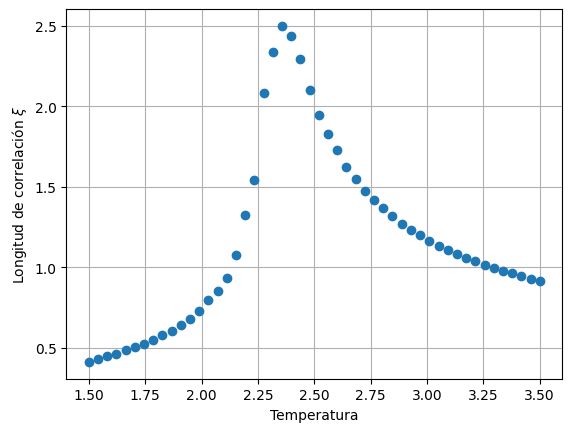

In [ ]:
Tc_est = Tarr[xi.argmax()]
print(r"La máxima longitud de correlación se dio para: T={Tc_est}".format(Tc_est=round(Tc_est,3)))

La máxima longitud de correlación se dio para: T=2.357


**Explanation:**

We used the same code as for the 3 correlation function curves, but this time we swept across 50 different temperatures. Instead of plotting these fits, we saved the values of $\xi$ obtained from the correlation function fit for each temperature into an array.

With these values, we plotted the figure shown above, which represents the correlation length $\xi$ as a function of each simulated temperature.

The highest value of $\xi$ was obtained for a temperature of $T \approx 2.357$, indicating that the critical temperature $T_c$ for a lattice with side length $L=30$ is around this value. This will be verified later with a more precise method.



**Explanation:**

We used the same approach as for studying the behavior of susceptibility $\chi$ with respect to temperature variations, but this time we performed a fine scan around the peak of $\chi(T)$. This was done for the 4 values of $L$ specified in the problem statement. For each case, we fitted the susceptibility peak using ordinary least squares with the expression:

$$ \chi = b(T - T_c(L))^2 + c $$

From the fit, we obtained the parameters $b$, $c$, and $T_c(L)$. It is important to note that the parameter $T_c(L)$ from the fit corresponds to the 'x_max' of the quadratic function, so its uncertainty (i.e., the square root of the parameter variance) was directly computed by the curve-fit library without needing to perform any error propagation. The figures below report the value of $T_c(L)$.

This procedure was performed for the values of $L = 15, 30, 60, 120$, and for each case, an increasing number of thermalization steps was used, as the system took longer to stabilize the magnetization averages. We used $n = 20000, 40000, 120000, 350000$ steps respectively. These numbers were chosen based on the curves from the 'Averages' section for each $L$. We selected the $n$ where the curve stabilized and overestimated it to further reduce fluctuations and thus the uncertainty of the parameter $T_c(L)$.

With the values of $T_c(L)$, we fitted the relation:

$$ T_c(L) = T_c + \frac{a}{L} $$

to obtain a value for $T_c$, which would be the intercept of the fit, where $a$ is a constant parameter. The fitting considered the errors in the $T_c(L)$ parameters. We found $T_c = 2.268 \pm 0.0019$, noting that this value has a relative uncertainty of less than 1%. This value is similar to the one suggested at the beginning of the study.


Susceptibilidad en función de la temperatura (alrededor de la temperatura crítica) para diferentes valores de longitud de red (15, 30, 60, 120):


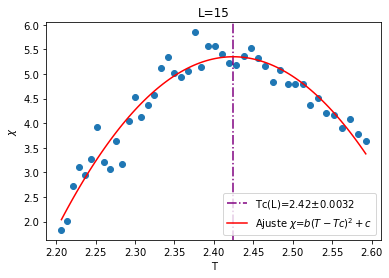

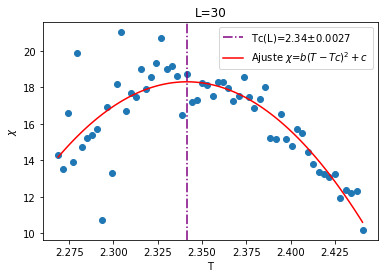



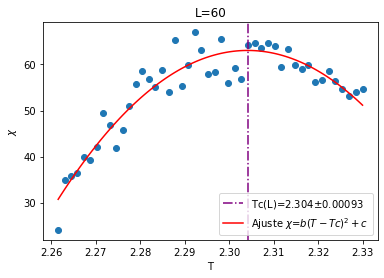

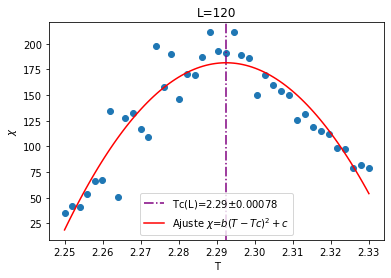

Note that the critical temperature $T_c(L=30) = 2.34$ is the one that most closely matches the predicted value from the correlation length analysis, which was $T_c(L=30) = 2.37$.

Another notable aspect is that as $L$ is doubled, the maximum value of the susceptibility approximately triples. This makes sense since, in the thermodynamic limit, $\chi(T_c)$ is expected to diverge. Additionally, the $T_c(L)$ values decrease, as we would expect if, in the thermodynamic limit, this value converges to $T_c \approx 2.27$.


A continuación se muestra el ajuste lineal de las temperaturas críticas en función de la inversa de la logitud de las redes.

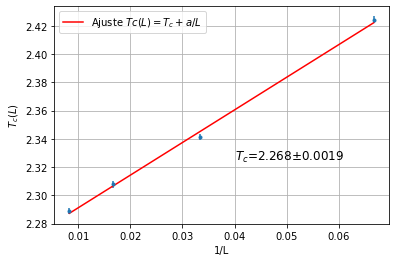

The critical temperature obtained for the thermodynamic limit was $T_c = 2.268 \pm 0.002$, a value that does not show significant differences from the $T_c = 2.27$ stated at the beginning of this work.
